In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import random
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator, img_to_array
from os import walk
import shutil
import cv2     #resizing th image
from random import shuffle  #shuffle images
from tqdm import tqdm  #professional looping with progressbar
#import tensorflow as tf
import pandas as pd
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Dropout, Conv2D, MaxPool2D
from tensorflow.keras.activations import relu, softmax, tanh, sigmoid
from tensorflow.keras.losses import sparse_categorical_crossentropy, CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
import glob

In [2]:
# Data Augmentation
def data_rotate():
    data_gen = ImageDataGenerator(rotation_range=20, # Amount of rotation
                                  width_shift_range=0.1,# Amount of shift
#                                  height_shift_range=0.1,
                                  shear_range=0.2,# Shear angle in counter-clockwise direction as radians
                                  zoom_range=0.4,# Range for random zoom
                                  horizontal_flip=True,# Boolean (True or False). Randomly flip inputs horizontally
                                  #vertical_flip=True,
                                  fill_mode="constant",cval=255)# Points outside the boundaries of the input are filled
                                                      # according to the given mode
    return data_gen

# Import folder
def load_dataset(path):
    DIR='AUG'
    data_gen = data_rotate()
    f = []
    if os.path.exists(DIR) == True:
        shutil.rmtree(DIR) 
    print('Folder Emplied')
    
    os.mkdir(DIR)
    for (dir_path, dir_names, file_names) in walk(path): # Find all images in folder
        f.extend(file_names)
    for item in f: # For each image in folder
        image = Image.open(path+'/'+item).convert('L') # Create a numpy array with shape (1, 500, 500)
        x = img_to_array(image)
        x_label = item.split('.')[-2] #x = np.asarray(x) # Convert to a numpy array with shape (1, 1, 500, 500)
        x = x.reshape((1,) + x.shape)   
        i = 0
        for batch in data_gen.flow(x, save_to_dir=DIR, save_prefix=x_label, save_format='jpg'):
            i += 1
            if i > 3 : #determine number of additional images per origional image
                break             
    print('Data Augmentation finished.\n')

def data_reg(path):
    e = 1 #is regenerate, 0 is keep origional
    if e == 1:   
        load_dataset(path)
        
data_reg('summer2021_data') # run the data regenration
#end of data aug

Folder Emplied
Data Augmentation finished.



In [3]:
# train_image
def image_iden():
    TRAIN_DIR = 'summer2021_data'
    TRAIN_AUG = 'AUG'#image=cv2.imread('Training/000016.jpg') #plt.imshow(image)  #plt.show()
    IMG_SIZE = 100 #LR = 1e-3   #MODEL_NAME = 'Soybean'.format(LR, 'classify')   
    dataset = pd.read_csv('summer2021_label.csv')
    file_names = list(dataset['file_name'].values)
    img_labels = list(dataset['annotation'].values)
    return  TRAIN_DIR, TRAIN_AUG, IMG_SIZE, dataset, file_names, img_labels

TRAIN_DIR, TRAIN_AUG, IMG_SIZE, dataset, file_names, img_labels = image_iden()

def label_img_orignal(img):
    word_label = img.split('.')[-2] #eg: 000006.jpg
    for i in range(len(img_labels)):
        if word_label == file_names[i].split('.')[-2]:
            return img_labels[i], word_label
        
def label_img_aug(img):
    word_label=img.split('_')[-3]
    for i in range(len(img_labels)):
        if word_label == file_names[i].split('.')[-2]:
            return img_labels[i], word_label
    
def create_train_data_orignal():
    train_data = []
    for img in tqdm(os.listdir(TRAIN_DIR)):
        label, word = label_img_orignal(img)
        path = os.path.join(TRAIN_DIR,img)
        img = cv2.resize(cv2.imread(path,cv2.IMREAD_GRAYSCALE), (IMG_SIZE, IMG_SIZE))
        train_data.append([np.array(img), np.array(label), np.array(word)])    
    shuffle(train_data)
    np.save('summer2021_original.npy', train_data)   #in future we can load this file
    return train_data                           
                           
def create_train_data_aug(): 
    train_data = []
    for img in tqdm(os.listdir(TRAIN_AUG)):
        label,word = label_img_aug(img)
        path = os.path.join(TRAIN_AUG,img)
        img = cv2.resize(cv2.imread(path,cv2.IMREAD_GRAYSCALE), (IMG_SIZE, IMG_SIZE))
        train_data.append([np.array(img), np.array(label),np.array(word)]) 
    shuffle(train_data)
    np.save('summer2021_aug.npy', train_data)
    return train_data

def create_test_data(): 
    test_images = []
    for f in glob.iglob('summer2021_test/*'):
        i = cv2.resize(cv2.imread(f,cv2.IMREAD_GRAYSCALE),(IMG_SIZE,IMG_SIZE))
        i = i.reshape(IMG_SIZE,IMG_SIZE,1)
        test_images.append(i)
    test_images = np.array(test_images)
    return test_images

        
def activation_fcn(x):
    if x == "relu":
        return relu
    elif x == "tanh":
        return tanh
    elif x == "softmax":
        return softmax
    elif x == "sigmoid":
        return sigmoid

In [4]:
def model_structure(input, activation_fn, learning_rate,num_neurons_in_dense, num_classes, drop_out, kernel, filter_size): 
    model=Sequential()
    model.add(Conv2D(
            filters=filter_size,
            kernel_size=[kernel,kernel],
            input_shape=input,
            padding="same",
            activation=activation_fn
            ))
    model.add(BatchNormalization())
    model.add(MaxPool2D(
            pool_size=[2,2],
            strides=2))
    model.add(Conv2D(
            filters=filter_size,
            kernel_size=[kernel,kernel],
            padding = "same",
            activation = activation_fn
            ))
    model.add(BatchNormalization())
    model.add(MaxPool2D(
            pool_size=[2,2],
            strides=2
            ))
    model.add(Flatten())
    model.add(Dense(
               units=num_neurons_in_dense,
               activation=activation_fn))
    model.add(Dropout(drop_out))
    model.add(Dense(units = num_classes,
                    activation=softmax))
    model.compile(
            loss = sparse_categorical_crossentropy,
            optimizer=Adam(lr=learning_rate),  
            metrics=["accuracy"])
    model.summary()
    return model     

In [5]:
def train_model(model, train_images, train_labels, batch_size, num_epochs, valid_images, valid_labels):
#                ,save_callback, tb_callback
#                ):
    history = model.fit(
            x = train_images,
            y = train_labels,
            batch_size = batch_size,
            epochs= num_epochs,
            validation_data=(valid_images, valid_labels),
            shuffle = True)
#            callbacks=[save_callback, tb_callback])
            #verbose = 0
    history_dict=history.history
    train_accuracy=history_dict["accuracy"]
    train_loss = history_dict["loss"]
    valid_accuracy = history_dict["val_accuracy"]
    valid_loss = history_dict["val_loss"]
    return train_accuracy, train_loss, valid_accuracy, valid_loss

# end of train image

def data_split():
    train_data_orig = create_train_data_orignal()
    train_data_aug = create_train_data_aug()
    data=train_data_orig+train_data_aug
    random.shuffle(data)
    #IMG_SIZE = 100
    X=[]
    Y=[]
    Z=[]
    for features, labels, words in data:
        X.append(features)
        Y.append(labels)
        Z.append(words)
    X=np.array(X).reshape(-1,IMG_SIZE,IMG_SIZE,1) 
    Y=np.array(Y)
    Z=np.array(Z)
    valid_set_size = int(np.floor(len(X)/4))
    split = len (X) - valid_set_size
    valid_images = X[split :]
    valid_labels = Y[split :]
    valid_words = Z[split :]
    train_images = X[: split]
    train_labels = Y[: split]
    train_words = Z[: split]
    return train_images, train_labels,train_words, valid_images, valid_labels, valid_words
    
def strucmodel(lr, acf, neurons_size, drop_out, kernel, filter_size):
    learning_rate = lr
    num_neurons_in_dense = neurons_size
    active_fn = acf
    activation_fn = activation_fcn(active_fn)
    num_channels = 1
    input_shape = [IMG_SIZE, IMG_SIZE, num_channels]
    num_classes = 17
#    folder = os.path.join(os.getcwd(), datetime.now().strftime("%d-%m_%Y_%M-%S"), str(active_fn))
#    history_file = folder + "\soybean" + str(active_fn) + ".h5"
#    save_callback = ModelCheckpoint(filepath = history_file, verbose = 1)
#    tb_callback = TensorBoard(log_dir = folder)
    model = model_structure(input_shape, activation_fn, learning_rate, num_neurons_in_dense, num_classes, drop_out, kernel, filter_size)
    #t0 = time.time()
    return model

In [6]:
def test_model(model, test_images, test_labels):
    test_loss, test_accuracy = model.evaluate(
            x = test_images,
            y = test_labels,
            verbose = 0
            )
    predictions = model.predict_proba(
            x = test_images,
            batch_size=None,
            verbose=0)
    return test_accuracy, test_loss, predictions

In [7]:
def runmodel(train_images, train_labels, valid_images, valid_labels, model, epoch, batch, lr, acf):   
    test_images = create_test_data()
    num_epochs = epoch
    batch_size = batch
    active_fn = acf
    train_accuracy, train_loss, valid_accuracy, valid_loss = train_model(model, train_images, train_labels, batch_size, num_epochs, valid_images, valid_labels)#, save_callback, tb_callback)
    num_epochs_plot = range(1, len(train_accuracy) + 1)
    plt.figure(1)
    plt.plot(num_epochs_plot, train_loss, "b", label="Training Loss")
    plt.plot(num_epochs_plot, valid_loss, "r", label="Validation Loss")
    plt.title("Loss Curves_" + active_fn)
    plt.xlabel("Number of Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.savefig('Figures/' + active_fn + '_loss.png')
    plt.show()
    plt.figure(2)
    plt.plot(num_epochs_plot, train_accuracy, "b", label="Training Accuracy")
    plt.plot(num_epochs_plot, valid_accuracy, "r", label="Validation Accuracy")
    plt.title("Accuracy Curves_" + active_fn)
    plt.xlabel("Number of Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.savefig('Figures/' + active_fn + '_acc.png')
    plt.show()
    prediction = np.argmax(model.predict(test_images), axis=-1)
    result = np.zeros((test_images.shape[0],np.max(train_labels)+1))
    result[np.arange(test_images.shape[0]),prediction] = 1
    np.savetxt('labels21.csv', result , delimiter=',',fmt='%i')
    return train_accuracy, train_loss, valid_accuracy, valid_loss   
    
    
def tun():
    train_images, train_labels, valid_images, valid_labels = data_split()
    acf = 'relu'
    accuracy = ''
    for e in range(3):
        e = 5*e
        epoch = 2*e
        for q in range(4):
            q = q
            lr = 0.0001*np.power(10,q)
            for n in range(4):
                n = n
                batch = 128*np.power(2,n)
                model = strucmodel(lr, acf, neurons_size, drop_out, kernel, filter_size)
                valid_accuracy, valid_loss = runmodel(train_images, train_labels, valid_images, valid_labels, model, epoch, batch, lr, acf)
            r = 'The loss is : %s, The accuracy is: %s (Batch: %s, Learning_rate: %s)'%(valid_loss[-1], valid_accuracy[-1], batch, lr)
            print(r)
            accuracy = accuracy+','+r
    accuracy = accuracy
    return accuracy

In [8]:
train_images, train_labels, train_words, valid_images, valid_labels, valid_words = data_split()

100%|██████████| 1442/1442 [00:25<00:00, 57.59it/s]
D:\Anaconda\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
100%|██████████| 5768/5768 [00:55<00:00, 104.83it/s]


In [9]:
kernel=3
filter_size=64
neurons_size=128
drop_out=0.5
acf = 'relu'
lr =0.001
epoch = 25
batch_size = 128
model = strucmodel(lr, acf, neurons_size, drop_out, kernel, filter_size)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 64)      640       
_________________________________________________________________
batch_normalization (BatchNo (None, 100, 100, 64)      256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 50, 50, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 40000)             0

Epoch 1/25
43/43 [==============================] - 101s 2s/step - loss: 2.8902 - accuracy: 0.4101 - val_loss: 6.6545 - val_accuracy: 0.2331
Epoch 2/25
43/43 [==============================] - 111s 3s/step - loss: 1.2555 - accuracy: 0.6115 - val_loss: 2.6328 - val_accuracy: 0.3541
Epoch 3/25
43/43 [==============================] - 113s 3s/step - loss: 0.9820 - accuracy: 0.6888 - val_loss: 1.5445 - val_accuracy: 0.5538
Epoch 4/25
43/43 [==============================] - 112s 3s/step - loss: 0.8309 - accuracy: 0.7337 - val_loss: 0.6334 - val_accuracy: 0.8169
Epoch 5/25
43/43 [==============================] - 110s 3s/step - loss: 0.6742 - accuracy: 0.7781 - val_loss: 0.5420 - val_accuracy: 0.8191
Epoch 6/25
43/43 [==============================] - 126s 3s/step - loss: 0.6643 - accuracy: 0.7768 - val_loss: 0.4307 - val_accuracy: 0.8690
Epoch 7/25
43/43 [==============================] - 116s 3s/step - loss: 0.6070 - accuracy: 0.7911 - val_loss: 0.6845 - val_accuracy: 0.8235
Epoch 8/25
43

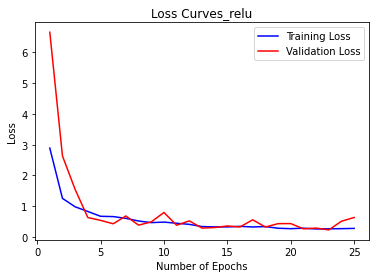

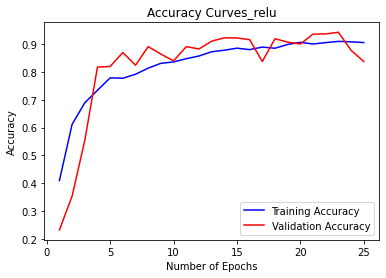

In [10]:
train_accuracy, train_loss, valid_accuracy, valid_loss = runmodel(train_images, train_labels, valid_images, valid_labels, model, epoch, batch_size, lr, acf)

In [11]:
model.save('n3')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: n3\assets


In [ ]:
writer = pd.ExcelWriter('zzz.xlsx', engine='xlsxwriter')
dk = pd.DataFrame(data=np.vstack((train_accuracy,train_loss,valid_accuracy,valid_loss)).T,columns = ["accuracy","loss","accuracy","loss"])
dk.to_excel(writer, header = True, index = True, startrow=0, startcol=0, float_format='%.4f')
writer.save()

In [ ]:
model = keras.models.load_model('m2')

In [ ]:
def test_data(): 
    test_images = []
    test_names = []
    for f in glob.iglob('summer2021_test/*'):
        i = cv2.resize(cv2.imread(f,cv2.IMREAD_GRAYSCALE),(IMG_SIZE,IMG_SIZE))
        i = i.reshape(IMG_SIZE,IMG_SIZE,1)
        test_images.append(i)
        test_names.append(f)
    test_images = np.array(test_images)
    test_names = np.array(test_names)
    return test_images, test_names

In [ ]:
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score
import random as r
r.seed(523)
test_images, test_names = test_data()
test_labels = pd.read_excel('test_label.xlsx')
test_pred = np.argmax(model.predict(test_images), axis=-1)
y_encoded = to_categorical(test_labels)
y_prob = model.predict(test_images)
accuracy_score(test_labels, test_pred)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score
from itertools import cycle
from scipy import interp
num_class=17
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
thresh = dict()
roc_auc = dict()
for i in range(num_class):
    fpr[i], tpr[i], thresh[i] = roc_curve(y_encoded[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], thresh["micro"] = roc_curve(y_encoded.ravel(), y_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [ ]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_class)]))
lw=1
# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_class):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= num_class

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(10, 8), dpi=80)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.5f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.5f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [ ]:
test_l=test_labels.values.flatten()

In [ ]:
zz=np.where(test_l!=test_pred)

In [ ]:
xx=pd.DataFrame(data=np.vstack((valid_words[zz],valid_labels[zz],y_predict[zz])).T, columns=["Image","True_label","Predicted_label"])
xx

In [ ]:
plt.imshow(valid_images[895],'gray')

In [ ]:
model.predict(valid_images)[895]

In [ ]:
valid_images[1024].shape

In [ ]:
writer = pd.ExcelWriter('xxx.xlsx')
xx.to_excel(writer,'page_1',float_format='%.5f')  #Key 3, float_format controls the accuracy, write data_df to the first page of the hhh form. If there are multiple files, you can write in page_2
writer.save()  #Key 4

In [ ]:
fig=plt.figure(figsize=(18,18),dpi=70)
columns = 4
rows = 5
for i in range(1,num_class+1):
    ax=fig.add_subplot(rows, columns, i)
    plt.plot(fpr[i-1], tpr[i-1], color='darkorange', lw=2,
             label='ROC curve of class {0} (area = {1:0.5f})'
             ''.format(i-1, roc_auc[i-1]))
    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
plt.show()

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
macro_roc_auc_ovo = roc_auc_score(y_encoded, y_prob, multi_class="ovo",
                                  average="macro")
weighted_roc_auc_ovo = roc_auc_score(y_encoded, y_prob, multi_class="ovo",
                                     average="weighted")
macro_roc_auc_ovr = roc_auc_score(y_encoded, y_prob, multi_class="ovr",
                                  average="macro")
weighted_roc_auc_ovr = roc_auc_score(y_encoded, y_prob, multi_class="ovr",
                                     average="weighted")
print("One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
print("One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovr, weighted_roc_auc_ovr))

In [ ]:
writer = pd.ExcelWriter('kkk.xlsx', engine='xlsxwriter')
for i in range(num_class):
        data_df = pd.DataFrame(data=np.vstack((fpr[i],tpr[i],thresh[i])).T,  columns = ["fpr","tpr","threshold"])
        data_df.to_excel(writer, header = True, index = True, startrow=0, startcol=5*i, float_format='%.4f')
writer.save()

In [ ]:
writer = pd.ExcelWriter('hhh.xlsx')  #Key 2, create an excel sheet named hhh
data_df.to_excel(writer,'page_1',float_format='%.5f')  #Key 3, float_format controls the accuracy, write data_df to the first page of the hhh form. If there are multiple files, you can write in page_2
writer.save()  #Key 4